In [1]:
# 需要Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# 需要Scikit-Learn ≥0.20 
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# 需要TensorFlow ≥2.0 
import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import pandas as pd
import os

# 让每次运行的结果稳定
np.random.seed(42)

# 让画出的图像效果更好
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 自动创建images文件夹
PROJECT_ROOT_DIR = "."
IMAGE_FILE = "images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGE_FILE)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    运行即可自动保存图片
    
    :param fig_id: 图片的名称
    :tight_layout: 自动调整图片的坐标轴
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 忽略掉没有用的警告 (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import tensorflow as tf

In [3]:
# 查看TensorFlow的版本
tf.__version__

'2.1.0'

In [4]:
# 查看Keras的版本
tf.keras.__version__

'2.2.4-tf'

In [5]:
raw_data = pd.read_excel("hydrogen_test_classification.xlsx")
raw_data.head()

TRUE VALUE  SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  CR2O3(WT%)  FEOT(WT%)  \
0           1    49.4200     0.7771      0.5047      0.0196    23.2200   
1          -1    55.4236     0.2302      7.9009      0.0768     3.1775   
2           1    55.7368     0.2486      5.8661      0.1236     2.9318   
3           1    54.8200     0.2900      3.4300      0.2200     5.9200   
4          -1    54.7000     0.1700      1.5400      0.0200     6.8800   

   CAO(WT%)  MGO(WT%)  MNO(WT%)  NA2O(WT%)  ...      PR(PPB)       ND(PPB)  \
0   17.8500    6.6800    0.8421     0.2652  ...  3722.193112  15286.752450   
1   15.0067   13.6203    0.0780     3.5551  ...  1404.899518   7334.225012   
2   16.6816   14.8219    0.0767     3.2461  ...  2045.355178   9016.002637   
3   17.4100   14.1700    0.0001     3.1700  ...  2574.159825  14995.256360   
4   19.1400   14.3900    0.0001     2.1800  ...  1080.000000   3790.000000   

       SM(PPB)      EU(PPB)      GD(PPB)      DY(PPB)      ER(PPB)  \
0  2496.972275   771.341005  1615.571766  1043.106268   679.293908   
1  1581.714783   440.534631  1075.024781   456.772767   106.450006   
2  2564.537120  1118.437460  2882.436657  4479.791591  2590.481678   
3  4145.128868  1432.173091  4015.452788  2864.960991  1020.780199   
4   458.000000   119.600000   260.000000    61.500000     8.470000   

       YB(PPB)     LU(PPB)      TH(PPB)  
0   620.002530   99.000000  2117.083155  
1    56.000000    7.190000    18.012303  
2  2645.268490  275.616274   343.599927  
3   696.964682   82.247877    42.500000  
4     2.580000    0.620000   184.200000  

[5 rows x 26 columns]

In [6]:
# 检查数据集是否有空值
raw_data.isnull().sum()

TRUE VALUE    0
SIO2(WT%)     0
TIO2(WT%)     0
AL2O3(WT%)    0
CR2O3(WT%)    0
FEOT(WT%)     0
CAO(WT%)      0
MGO(WT%)      0
MNO(WT%)      0
NA2O(WT%)     0
SR(PPB)       0
Y(PPB)        0
ZR(PPB)       0
NB(PPB)       0
LA(PPB)       0
CE(PPB)       0
PR(PPB)       0
ND(PPB)       0
SM(PPB)       0
EU(PPB)       0
GD(PPB)       0
DY(PPB)       0
ER(PPB)       0
YB(PPB)       0
LU(PPB)       0
TH(PPB)       0
dtype: int64

In [7]:
"""
# 如果有空值，需进行插值
raw_data.fillna(1)
"""

'\n# 如果有空值，需进行插值\nraw_data.fillna(1)\n'

In [8]:
# 分开特征值和标签值
X = raw_data.drop("TRUE VALUE", axis=1).copy()
y = raw_data["TRUE VALUE"]
y.unique()

array([ 1, -1])

In [9]:
from sklearn.model_selection import train_test_split

# 分训练集、验证集和测试集
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [10]:
# 查看特征的维度
X_train.shape

(1508, 25)

# Sequential API

In [201]:
# 销毁当前的 TF 图并创建一个新图,避免旧模型/网络层混乱
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# input_shape 填特征的维度，是特征变为一维特征的形式
model = Sequential()
# model.add(Flatten(input_shape=[25]))
model.add(Dense(300, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dense(100, activation="tanh"))
model.add(Dense(1, activation="sigmoid"))

In [203]:
# 查看构建
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               7800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 38,001
Trainable params: 38,001
Non-trainable params: 0
_________________________________________________________________


In [204]:
# 获取神经网络的层信息
model.layers

In [212]:
# 获取第一层隐藏层的名字
hidden1 = model.layers[0]
hidden1.name

'dense'

In [206]:
model.get_layer("dense_2").name

'dense_2'

In [207]:
weights, biases = hidden1.get_weights()

In [208]:
# 获取第一层隐藏层的权重，还未训练前，权重为随机赋值
weights

array([[ 0.04602376, -0.0038019 ,  0.10557164, ...,  0.05382182,
        -0.09810888,  0.10975555],
       [-0.0131605 , -0.0401491 , -0.01301397, ..., -0.06764732,
        -0.05142808, -0.10832162],
       [ 0.0748878 ,  0.11689269,  0.06693598, ...,  0.04704887,
        -0.04119989,  0.1031863 ],
       ...,
       [-0.08606555,  0.1186113 , -0.11932244, ...,  0.1080649 ,
        -0.10135629,  0.05048553],
       [-0.1144025 , -0.06622341,  0.00440084, ..., -0.00439373,
         0.01447021,  0.02337808],
       [-0.10965011,  0.05632766,  0.11904002, ..., -0.0713827 ,
         0.11915682, -0.10558839]], dtype=float32)

In [209]:
weights.shape

(300, 100)

In [210]:
# 获取第一层隐藏层的偏置，还未训练前，为默认值0
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [211]:
biases.shape

(100,)

In [165]:
# optimizer可选择为sgd或者是adam
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [166]:
# 如果训练集的标签值类型数量偏差大，可使用超参数class_weight
history = model.fit(X_train, y_train, epochs=30, verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 1508 samples, validate on 378 samples
Epoch 1/30
1508/1508 [==============================] - 0s 280us/sample - loss: -1.7146 - accuracy: 0.1174 - val_loss: -3.0969 - val_accuracy: 0.1481
Epoch 2/30
1508/1508 [==============================] - 0s 42us/sample - loss: -4.2360 - accuracy: 0.1499 - val_loss: -5.4743 - val_accuracy: 0.2751
Epoch 3/30
1508/1508 [==============================] - 0s 41us/sample - loss: -6.7781 - accuracy: 0.1698 - val_loss: -7.6559 - val_accuracy: 0.1032
Epoch 4/30
1508/1508 [==============================] - 0s 46us/sample - loss: -9.3803 - accuracy: 0.1638 - val_loss: -9.8832 - val_accuracy: 0.4550
Epoch 5/30
1508/1508 [==============================] - 0s 43us/sample - loss: -12.0386 - accuracy: 0.1897 - val_loss: -13.6091 - val_accuracy: 0.1508
Epoch 6/30
1508/1508 [==============================] - 0s 43us/sample - loss: -15.1574 - accuracy: 0.1850 - val_loss: -11.4698 - val_accuracy: 0.4762
Epoch 7/30
1508/1508 [==============================] 

In [167]:
# 经训练的神经网络的重要信息
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 48,
 'samples': 1508,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [168]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


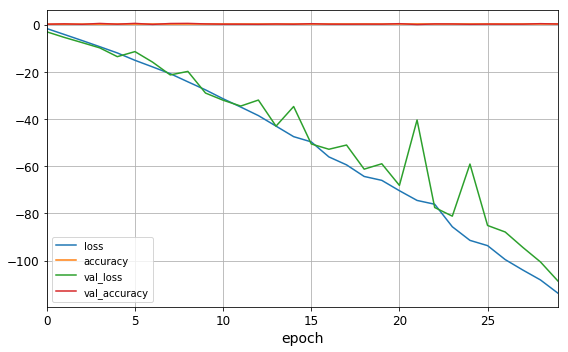

In [195]:
# 在一张图上画出loss和accuracy的
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("epoch")
plt.grid(True)
# plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

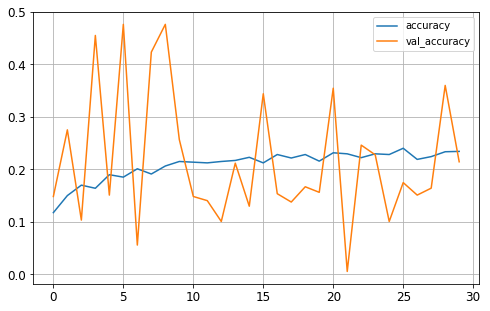

In [196]:
a = ["accuracy", "val_accuracy"]
plt.figure(figsize=(8, 5))
for i in a:
    plt.plot(history.history[i], label=i)
    plt.legend()
plt.grid(True)

In [171]:
# 测试集的评分
model.evaluate(X_test, y_test)

472/472 [==============================] - 0s 39us/sample - loss: -106.1649 - accuracy: 0.1949


[-106.16492908283816, 0.19491525]

In [199]:
# 测试集中数据被分类为1的概率
y_proba = model.predict(X_test)
y_proba

array([[0.00000000e+00],
       [0.00000000e+00],
       [9.74971831e-01],
       [0.00000000e+00],
       [4.67124254e-01],
       [7.25144215e-24],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.20567799e-05],
       [0.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.50083184e-18],
       [0.00000000e+00],
       [0.00000000e+00],
       [4.24115406e-03],
       [1.26977682e-07],
       [2.20567799e-05],
       [0.00000000e+00],
       [2.25291969e-05],
       [7.25144215e-24],
       [1.09837379e-06],
       [0.00000000e+00],
       [3.61661786e-12],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],


In [200]:
# 测试集的预测分类标签
y_pred = model.predict_classes(X_test)
y_pred

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
    